<a href="https://colab.research.google.com/github/Toxxi-frank/Deeplearning/blob/main/Anti_Deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
4/1AX4XfWi7fZ2sinYWYankoAOIcu4siadAZep5ic4r-3gSABS_IQNj95EsymQ

In [7]:
import glob
import os
import random
import shutil
from math import floor

# Path to directory where the downloaded data is
DATA_DIR = "/content/drive/MyDrive/DATN/deepfake_database/deepfake_database"
# Path to directory where new dataset should be created
TARGET_DIR = "/content/drive/MyDrive/DATN/dataset"

# Name of the sub-directory containing real images in DATA_DIR
REAL_DIR = "real"
# Name of the sub-directory containing fake images in DATA_DIR
FAKE_DIR = "df"
# Amount of data that should be put in the test set
PROP = 0.10


def create_target_dirs():
    r_train = os.path.join(TARGET_DIR, "train", REAL_DIR)
    f_train = os.path.join(TARGET_DIR, "train", FAKE_DIR)

    os.makedirs(r_train)
    os.makedirs(f_train)

    r_test = os.path.join(TARGET_DIR, "test", REAL_DIR)
    f_test = os.path.join(TARGET_DIR, "test", FAKE_DIR)

    os.makedirs(r_test)
    os.makedirs(f_test)


def main():
    if not os.path.exists(DATA_DIR):
        raise FileNotFoundError(f"{DATA_DIR} does not exist")

    if not os.path.isdir(DATA_DIR):
        raise NotADirectoryError(f"{DATA_DIR} is not a directory")

    shutil.rmtree(TARGET_DIR, ignore_errors=True)

    path = os.path.join(DATA_DIR, "**", "*.jpg")
    imgs = glob.glob(path, recursive=True)

    num_imgs = len(imgs)

    test_size = floor(len(imgs) * PROP)
    train_size = num_imgs - test_size

    while True:
        print(f"Creating directories at {TARGET_DIR}....")
        create_target_dirs()
        selected = random.sample(imgs, test_size)

        train_r_len = len(
            [1 for img in imgs if REAL_DIR in img and img not in selected]
        )
        train_f_len = train_size - train_r_len
        test_r_len = len([1 for img in selected if REAL_DIR in img])
        test_f_len = test_size - test_r_len

        print(f"Found {num_imgs} images in {DATA_DIR}....")
        print(f"Copying {train_size} files to {TARGET_DIR}/train/....")
        print(f"Copying {test_size} files to {TARGET_DIR}/test/....")
        print(
            f"The training set will have {train_r_len} real images and {train_f_len} fake images...."
        )
        print(
            f"The test set will have {test_r_len} real images and {test_f_len} fake images..."
        )

        for img in imgs:
            leaf_dir = REAL_DIR if REAL_DIR in img else FAKE_DIR
            intr_dir = "test" if img in selected else "train"
            dst = os.path.join(TARGET_DIR, intr_dir, leaf_dir)
            shutil.copy(img, dst)

        prompt = input("Try again? [Yy/Nn] ")
        if prompt in ["n", "N"]:
            print("Exiting....")
            break

        print("\n\nTrying again....")
        print(f"Deleting {TARGET_DIR}....\n")
        shutil.rmtree(TARGET_DIR)


if __name__ == "__main__":
    main()

Creating directories at /content/drive/MyDrive/DATN/dataset....
Found 19456 images in /content/drive/MyDrive/DATN/deepfake_database/deepfake_database....
Copying 17511 files to /content/drive/MyDrive/DATN/dataset/train/....
Copying 1945 files to /content/drive/MyDrive/DATN/dataset/test/....
The training set will have 10391 real images and 7120 fake images....
The test set will have 1117 real images and 828 fake images...
Creating directories at /content/drive/MyDrive/DATN/dataset....


FileExistsError: ignored

In [1]:
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, ReLU, ELU, LeakyReLU, Dropout, Dense, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from math import floor, log
from datetime import datetime
import os

In [3]:
IMG_WIDTH = 256

In [8]:
def get_datagen(use_default_augmentation=True, **kwargs):
    kwargs.update({'rescale': 1./255})
    if use_default_augmentation:
        kwargs.update({
            'rotation_range': 15,
            'zoom_range': 0.2,
            'brightness_range': (0.8, 1.2),
            'channel_shift_range': 30,
            'horizontal_flip': True,
        })
    return ImageDataGenerator(**kwargs)

In [9]:
def get_train_data_generator(
    train_data_dir, 
    batch_size, 
    validation_split=None, 
    use_default_augmentation=True,
    augmentations=None
):
    if not augmentations:
        augmentations = {}

    train_datagen = get_datagen(
        use_default_augmentation=use_default_augmentation,
        validation_split=validation_split if validation_split else 0.0,
        **augmentations
    )
   
    train_generator = train_datagen.flow_from_directory(
        directory=train_data_dir,
        target_size=(IMG_WIDTH, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
    )

    validation_generator = None

    if validation_split:
        validation_generator = train_datagen.flow_from_directory(
            directory=train_data_dir,
            target_size=(IMG_WIDTH, IMG_WIDTH),
            batch_size=batch_size,
            class_mode='binary',
            subset='validation'
        )

    return train_generator, validation_generator

In [10]:
def get_test_data_generator(test_data_dir, batch_size, shuffle=False):
    test_datagen = get_datagen(use_default_augmentation=False)
    return test_datagen.flow_from_directory(
        directory=test_data_dir,
        target_size=(IMG_WIDTH, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=shuffle
    )

In [11]:
def activation_layer(ip, activation, *args):
    return {'relu': ReLU(*args)(ip),
            'elu': ELU(*args)(ip),
            'lrelu': LeakyReLU(*args)(ip)}[activation]

In [12]:
def conv2D(ip,
           filters,
           kernel_size,
           activation,
           padding='same',
           pool_size=(2, 2)):
    layer = Conv2D(filters,
                   kernel_size=kernel_size,
                   padding=padding)(ip)

    layer = activation_layer(layer, activation=activation)

    layer = BatchNormalization()(layer)

    return MaxPooling2D(pool_size=pool_size, padding=padding)(layer)

def fully_connected_layer(ip,
                          hidden_activation,
                          dropout):
    layer = Dense(16)(ip)
    layer = activation_layer(layer, hidden_activation, *[0.1,])
    return Dropout(rate=dropout)(layer)

In [13]:
def build_model(ip=Input(shape=(IMG_WIDTH, IMG_WIDTH, 3)),
                activation='relu',
                dropout=0.5,
                hidden_activation='lrelu'):
    
    layer = conv2D(ip, filters=8, kernel_size=(3, 3), activation=activation)

    layer = conv2D(layer, filters=8, kernel_size=(5, 5), activation=activation)

    layer = conv2D(layer, filters=16, kernel_size=(5, 5), activation=activation)

    layer = conv2D(layer, filters=16, kernel_size=(5, 5), activation=activation, pool_size=(4, 4))

    layer = Flatten()(layer)
    layer = Dropout(rate=dropout)(layer)

    layer = fully_connected_layer(layer, hidden_activation=hidden_activation, dropout=dropout)

    op_layer = Dense(1, activation='sigmoid')(layer)

    model = Model(ip, op_layer)

    return model

In [14]:
def evaluate_model(model, test_data_dir, batch_size):
    data = get_test_data_generator(test_data_dir, batch_size)
    return model.evaluate(data)


def predict(model, data, steps=None, threshold=0.5):
    predictions = model.predict(data, steps=steps, verbose=1)
    return predictions, np.where(predictions >= threshold, 1, 0)


def save_model_history(history, filename):
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f)

In [15]:
def get_activation_model(model, conv_idx):
    conv_layers = [layer for layer in model.layers if 'conv' in layer.name]
    selected_layers = [layer for index, layer in enumerate(conv_layers) if index in conv_idx]
    activation_model = Model(
        inputs=model.inputs,
        outputs=[layer.output for layer in selected_layers]
    )
    return activation_model

In [16]:
def plot_loss_curve(history):
    plt.plot(history.history['loss'], 'r', label='train')
    plt.plot(history.history['val_loss'], 'g', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
def get_classification_report(
    model, data_dir, batch_size=64,
    steps=None, threshold=0.5, output_dict=False
):
    data = get_test_data_generator(data_dir, batch_size=batch_size)
    predictions = predict(model, data, steps, threshold)
    predictions = predictions.reshape((predictions.shape[0],))
    return classification_report(data.classes, predictions, output_dict=output_dict)
def visualize_conv_layers_single_img(
    activations,
    conv_idx,
):
    images_per_row = 4

    for activation, idx in zip(activations, conv_idx):
        num_filters = activation.shape[-1]

        imgs = [activation[:, :, i] for i in range(num_filters)]

        num_rows = num_filters // images_per_row

        fig = plt.figure()
        grid = ImageGrid(fig, 111, (num_rows, images_per_row))

        for ax, im in zip(grid, imgs):
            ax.imshow(im, cmap='viridis')

        plt.title(f'Convolutional Layer {idx + 1}')
        plt.show()


def visualize_conv_layers(model, imgs, conv_idx):
    activation_model = get_activation_model(model, conv_idx)
    activations = activation_model.predict(imgs)

    num_imgs = imgs.shape[0]
    num_layers = len(conv_idx)

    for idx in range(num_imgs):
        img_activs = [activations[i][idx, :, :, :] for i in range(num_layers)]
        visualize_conv_layers_single_img(
            activations=img_activs, conv_idx=conv_idx
        )

In [17]:
def train_model(model,
                train_data_dir,
                validation_split=None,
                batch_size=32,
                use_default_augmentation=True,
                augmentations=None,
                epochs=30,
                lr=1e-3,
                loss='binary_crossentropy',
                compile=True,
                lr_decay=True,
                decay_rate=0.10,
                decay_limit=1e-6,
                checkpoint=True,
                stop_early=True,
                monitor='val_accuracy',
                mode='max',
                patience=20,
                tensorboard=True,
                loss_curve=True):
    
    run_time = datetime.now().strftime("%Y%m%d-%H%M%S")

    train_generator, validation_generator = get_train_data_generator(
        train_data_dir=train_data_dir,
        batch_size=batch_size,
        validation_split=validation_split,
        use_default_augmentation=use_default_augmentation,
        augmentations=augmentations
    )

    callbacks = []
    if checkpoint:
        filepath = f'run_{run_time}_best_model.hdf5'
        model_checkpoint = ModelCheckpoint(
            filepath, monitor='val_accuracy', verbose=1,
            save_best_only=True
        )
        callbacks.append(model_checkpoint)

    if stop_early:
        callbacks.append(
            EarlyStopping(
                monitor=monitor,
                mode=mode,
                patience=patience,
                verbose=1
            )
        )

    if tensorboard:
        log_dir = "logs/fit/" + run_time
        callbacks.append(TensorBoard(log_dir, histogram_freq=1, write_images=True))

    if compile:
        if lr_decay:
            num_times = floor(log(decay_limit / lr, decay_rate))
            per_epoch = epochs // num_times
            lr = ExponentialDecay(
                lr,
                decay_steps=(train_generator.samples // batch_size) * per_epoch,
                decay_rate=decay_rate,
                staircase=True,
            )
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    history = model.fit(
        train_generator,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=validation_generator.samples // batch_size if validation_generator else None,
    )

    if loss_curve:
        plot_loss_curve(history)

    return history

Found 14009 images belonging to 2 classes.
Found 3502 images belonging to 2 classes.
Epoch 1/50
437/437 [==============================] - ETA: 0s - loss: 0.5717 - accuracy: 0.7128
Epoch 00001: val_accuracy improved from -inf to 0.83056, saving model to run_20211127-135138_best_model.hdf5
437/437 [==============================] - 308s 684ms/step - loss: 0.5717 - accuracy: 0.7128 - val_loss: 0.4519 - val_accuracy: 0.8306
Epoch 2/50
437/437 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.8272
Epoch 00002: val_accuracy improved from 0.83056 to 0.88188, saving model to run_20211127-135138_best_model.hdf5
437/437 [==============================] - 322s 737ms/step - loss: 0.3841 - accuracy: 0.8272 - val_loss: 0.3124 - val_accuracy: 0.8819
Epoch 3/50
437/437 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8539
Epoch 00003: val_accuracy did not improve from 0.88188
437/437 [==============================] - 298s 683ms/step - loss: 0.3287 - accur

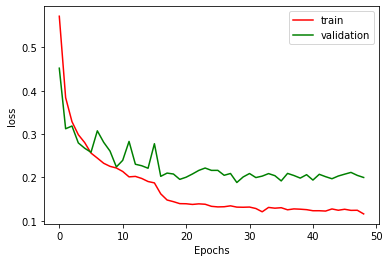

In [18]:
def main():
    train_data_dir = '/content/drive/MyDrive/DATN/dataset/train'# need changed
    val_split, epochs, batch_size = 0.20, 50, 64
    decay_rate, decay_limit = 0.10, 1e-6
    model = build_model()
    return model, train_model(
        model,
        train_data_dir,
        validation_split=val_split,
        epochs=epochs,
        decay_rate=decay_rate,
        decay_limit=decay_limit
    )

# !rm -rf logs
# %tensorboard --logdir logs/fit
model, history = main()

In [19]:
evaluate_model(model, '/content/drive/MyDrive/DATN/dataset/test', 64) # need change

Found 1945 images belonging to 2 classes.
31/31 [==============================] - 6s 195ms/step - loss: 0.0906 - accuracy: 0.9650


[0.09062524884939194, 0.965038537979126]

In [25]:
print(get_classification_report(model, '/content/drive/MyDrive/DATN/dataset/test')) #need change

Found 1945 images belonging to 2 classes.
31/31 [==============================] - 6s 195ms/step


ValueError: ignored

In [26]:
def get_classification_report(
    model, data_dir, batch_size=64,
    steps=None, threshold=0.5, output_dict=False
):
    data = get_test_data_generator(data_dir, batch_size=batch_size)
    predictions = predict(model, data, steps, threshold)
    
    return classification_report(data.classes, predictions, output_dict=output_dict)

In [31]:
test_data_dir = '/content/drive/MyDrive/DATN/dataset/test'
test_set = get_test_data_generator(test_data_dir, batch_size=64)

Found 1945 images belonging to 2 classes.


In [37]:
y_pred = model.predict_generator(test_set)
y_test = test_set.classes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [34]:
from sklearn import metrics
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.995330184803152
AP Score: 0.9965367969451524

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       828
           1       0.96      0.98      0.97      1117

    accuracy                           0.97      1945
   macro avg       0.97      0.96      0.96      1945
weighted avg       0.97      0.97      0.96      1945



In [51]:
print("Accuracy", metrics.accuracy_score(y_test, y_pred))

ValueError: ignored

In [38]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred>0.5).ravel()

a = fp / (fp+tn)
b = fn / (tp+fn)
c = 2*a*b / (a+b)
print(a, b, c)

0.05676328502415459 0.018800358102059087 0.02824559646286148


In [39]:
print(tn, fp, fn, tp)

781 47 21 1096


In [46]:

import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve

fpr,tpr,_ = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr, label='AUC = ' + str(round(roc_auc_score(y,m.oob_decision_function_[:,1]), 2)))
plt.legend(loc='lower right')
plt.show()

NameError: ignored

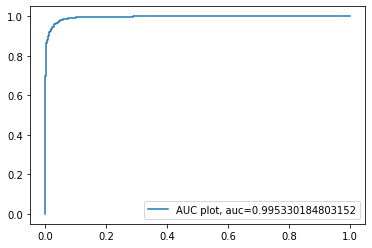

In [48]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="AUC plot, auc="+str(auc))
plt.legend(loc=4)
plt.show()

##Load_pre_trained_weights

In [21]:
model_exp = load_model('/content/drive/MyDrive/DATN/model1_18epochs_valacc0.9252.hdf5')

In [22]:
evaluate_model(model_exp, '/content/drive/MyDrive/DATN/dataset/test', 64) # need change

Found 1945 images belonging to 2 classes.
31/31 [==============================] - 6s 197ms/step - loss: 0.1006 - accuracy: 0.9604


[0.10064361989498138, 0.9604113101959229]

In [40]:
y_pred_1 = model_exp.predict_generator(test_set)
y_test_1 = test_set.classes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [49]:
from sklearn import metrics
print("ROC AUC Score:", metrics.roc_auc_score(y_test_1, y_pred_1))
print("AP Score:", metrics.average_precision_score(y_test_1, y_pred_1))
print()
print(metrics.classification_report(y_test_1, y_pred_1 > 0.5))

ROC AUC Score: 0.9950912338518895
AP Score: 0.9964209445982397

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       828
           1       0.95      0.98      0.97      1117

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945



In [42]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test_1, y_pred_1>0.5).ravel()

a = fp / (fp+tn)
b = fn / (tp+fn)
c = 2*a*b / (a+b)
print(a, b, c)

0.06884057971014493 0.017905102954341987 0.02841865160976704


In [43]:
print(tn, fp, fn, tp)

771 57 20 1097


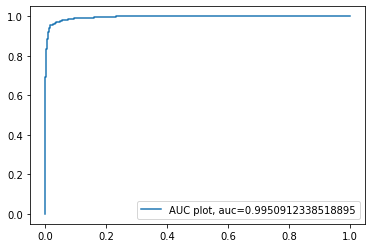

In [50]:
fpr, tpr, _ = metrics.roc_curve(y_test_1,  y_pred_1)
auc = metrics.roc_auc_score(y_test_1, y_pred_1)
plt.plot(fpr,tpr,label="AUC plot, auc="+str(auc))
plt.legend(loc=4)
plt.show()